In [1]:
cd ..

/home/mars/src_aiai


In [2]:
from src.sampling.uv_sampling import spider_sampling, random_sampling

In [ ]:
import tqdm
import numpy as np
import tensorflow as tf
from src.operators.kernels import calculate_kaiser_bessel_coef


class NUFFT2D_TF():
    """NUFFT implementation using a Kaiser-Bessel kernel for interpolation. 
    Implemented with TF operations. Only able to do the FFT on the last 2 axes 
    of the tensors provided. Slower than using the numpy_function on the np 
    based operations.
    """
    def __init__(self):
        pass
        
    def plan(self, uv, Nd, Kd, Jd, batch_size, measurement_weights=1, normalize=False):
        # saving some values
        self.Nd = Nd
        self.Kd = Kd
        self.Jd = Jd
        self.M = len(uv)
        self.measurement_weights = measurement_weights
        self.normalization_factor = 1
        self.batch_size = batch_size
        self.n_measurements = len(uv)
        gridsize = 2*np.pi / Kd[0]
        k = (uv + np.pi) / gridsize
        
        # calculating coefficients for interpolation
        indices = []
        values =  []
        for i in tqdm.tqdm(range(len(uv))):
            ind, vals = calculate_kaiser_bessel_coef(k[i], i, Jd)
            indices.append(ind)
            values.append(vals.real)
        
        # repeating the values and indices to match the batch_size 
        values = np.array(values).reshape(-1)
        indices = np.array(indices).reshape(-1, 4)
        
        batch_indices = np.tile(indices[:,-2:], [batch_size, 1])
        batch_indicators = np.repeat(np.arange(batch_size), (len(values)))
        self.batch_indices = np.hstack((batch_indicators[:,None], batch_indices))

        values = np.array(values).reshape(-1)
        self.batch_values = np.tile(values, [batch_size,1]).astype(np.float32).reshape(self.batch_size, self.n_measurements, self.Jd[0]*self.Jd[1])

        # check if indices are within bounds, otherwise suppress them and raise warning
        if np.any(self.batch_indices[:,-2:] < 0) or np.any(self.batch_indices[:,-2:] >= Kd[0]):
            self.sel_out_bounds = (np.any(self.batch_indices[:,-2:] < 0, axis=1) | np.any(self.batch_indices[:,-2:] >= Kd[0], axis=1))
            print(f"some values lie out of the interpolation array, these are not used, check baselines")
            
            # Since we want to keep the shape of the interpolation array the same, 
            # we will relocate the out of bounds indices to (0,0), 
            # but set the interpolation coefficients to zero so they are not counted. 
            self.batch_indices[self.sel_out_bounds] = np.zeros(self.batch_indices.shape[1])
            self.batch_values[self.sel_out_bounds.reshape(self.batch_values.shape)] = 0

        # determine scaling based on iFT of the KB kernel
        J = Jd[0] 
        beta = 2.34*J
        s_kb = lambda x: np.sinc(np.sqrt((np.pi *x *J)**2 - (2.34*J)**2 +0j)/np.pi)

        xx = (np.arange(Kd[0])/Kd[0] -.5)[Kd[0]//4:-Kd[0]//4] #TODO remove hard coded upsampling of factor 2 in slicing
        sa = s_kb(xx).real
        self.scaling = (sa.reshape(-1,1) * sa.reshape(1,-1)).reshape(1, Nd[0], Nd[0])
        self.scaling = tf.convert_to_tensor(self.scaling, dtype=tf.complex64)
        self.forward = self.dir_op
        self.adjoint = self.adj_op

        if normalize:
            self._normalize()

    def dir_op(self, xx):
        xx = tf.cast(xx, tf.complex64)
        xx = xx/self.scaling
        xx = self._pad(xx)
        kk = self._xx2kk(xx) / self.Kd[0]
        k = self._kk2k(kk)
        return k


    def adj_op(self, k, measurement_weighting=False):
        # split real and imaginary parts because complex operations not defined for sparseTensors
        if measurement_weighting:
            k = k * self.measurement_weights # weighting measurements
        kk = self._k2kk(k)
        xx = self._kk2xx(kk) * self.Kd[0]
        xx = self._unpad(xx)
        xx = xx / self.scaling
        if measurement_weighting:
            xx = xx / self.normalization_factor # normalising for operator norm
        return xx
    

    def _kk2k_sub(self, kk, sel):
        """interpolates of the grid to non uniform measurements"""
        batch_indices = self.batch_indices.reshape(-1, self.Jd[0]*self.Jd[1], 3)
        sel_batch_indices = tf.reshape(tf.boolean_mask(batch_indices, sel, axis=0), [-1,3])
        sel_batch_values = tf.cast(tf.boolean_mask(self.batch_values, sel, axis=1), tf.complex64)
        
        v = tf.gather_nd(kk, sel_batch_indices)
        r = tf.reshape(v, (self.batch_size, -1, self.Jd[0]*self.Jd[1])) * sel_batch_values
        return tf.reduce_sum(r, axis=2)

    def dir_op_sub(self, xx, sel):
        xx = tf.cast(xx, tf.complex64)
        xx = xx/self.scaling
        xx = self._pad(xx)
        kk = self._xx2kk(xx) / self.Kd[0]
        k = self._kk2k_sub( kk, sel)
        return k

    def _k2kk_sub(self, k_sub, sel):
        """convolutes measurements to oversampled fft grid"""
#         interp = k_sub[:,:,None] * self.batch_values[:, sel]
        interp = k_sub[:,:,None] * tf.cast(tf.boolean_mask(self.batch_values, sel, axis=1), tf.complex64)
        interp = tf.reshape(interp, [-1])

        batch_indices = self.batch_indices.reshape(-1, self.Jd[0]*self.Jd[1], 3)
        sel_batch_indices = tf.reshape(tf.boolean_mask(batch_indices, sel, axis=0), [-1,3])

        f = tf.scatter_nd(sel_batch_indices, interp, [self.batch_size] + list(self.Kd))
        return f

    def adj_op_sub(self, k, sel, measurement_weighting=False):
        # split real and imaginary parts because complex operations not defined for sparseTensors
        if measurement_weighting:
            k = k * self.measurement_weights # weighting measurements
        kk = self._k2kk_sub( k, sel)
        xx = self._kk2xx(kk) * self.Kd[0]
        xx = self._unpad(xx)
        xx = xx / self.scaling
        if measurement_weighting:
            xx = xx / self.normalization_factor # normalising for operator norm
        return xx

    def _kk2k(self, kk):
        """interpolates of the grid to non uniform measurements"""
        v = tf.gather_nd(kk, self.batch_indices)
        r = tf.reshape(v, (self.batch_size, self.n_measurements, self.Jd[0]*self.Jd[1])) * self.batch_values
        return tf.reduce_sum(r, axis=2)
        
    def _k2kk(self, k):
        """convolutes measurements to oversampled fft grid"""
        interp = k[:,:,None] * self.batch_values
        interp = tf.reshape(interp, [-1])

        f = tf.scatter_nd(self.batch_indices, interp, [self.batch_size] + list(self.Kd))
        return f
        
    @staticmethod
    def _kk2xx(kk):
        """from 2d fourier space to 2d image space"""
        return tf.signal.ifftshift(tf.signal.ifft2d(tf.signal.ifftshift(kk, axes=(-2,-1))), axes=(-2,-1)) 

    @staticmethod
    def _xx2kk(xx):
        """from 2d fourier space to 2d image space"""
        return tf.signal.fftshift(tf.signal.fft2d(tf.signal.fftshift(xx, axes=(-2,-1))), axes=(-2,-1))
    
    def _pad(self, x):
        """pads x to go from Nd to Kd"""
        return tf.pad(x, tf.constant([
            [0, 0],
            [(self.Kd[0]-self.Nd[0])//2, (self.Kd[0]-self.Nd[0])//2],
            [(self.Kd[1]-self.Nd[1])//2, (self.Kd[1]-self.Nd[1])//2]
        ]))
    
    def _unpad(self, x):
        """unpads x to go from  Kd to Nd"""
        return x[
            :,
            (self.Kd[0]-self.Nd[0])//2: (self.Kd[0]-self.Nd[0])//2 +self.Nd[0],
            (self.Kd[1]-self.Nd[1])//2: (self.Kd[1]-self.Nd[1])//2 +self.Nd[1]
            ] 

    def _normalize(self):
        # normalise operator norm on random (0,1) image
        t = np.random.normal(size=(self.batch_size, self.Nd[0], self.Nd[1])).astype(np.float32)
        t = (t - t.min())/(t.max()-t.min())
#         t = self.adj_op(self.dir_op(t))
        new_t = self.adj_op(self.dir_op(t), measurement_weighting=True)
        
        self.nu =  tf.norm(tf.math.real(new_t))/tf.norm(t)

In [4]:
    from src.data import load_M51

In [5]:
x = load_M51()
x /= x.max()


In [97]:
Nd = x.shape
Kd = (x.shape[0]*2, x.shape[1]*2)
Jd = (6,6)
batch_size = 1

uv = random_sampling(1000)

In [98]:
nufft_op = NUFFT2D_TF()
nufft_op.plan(uv, Nd, Kd, Jd, batch_size)

100%|██████████| 1000/1000 [00:00<00:00, 1483.68it/s]


In [99]:
random_sel = np.random.randint(0,2, size=len(uv)).astype(bool)

In [100]:
tf_sel = tf.convert_to_tensor(sel)

In [101]:
%%time
y_sub = nufft_op.dir_op_sub( x, random_sel)

CPU times: user 15.8 ms, sys: 2.77 ms, total: 18.5 ms
Wall time: 34.4 ms


In [102]:
%%time
y = nufft_op.dir_op(x)

CPU times: user 7.58 ms, sys: 2.71 ms, total: 10.3 ms
Wall time: 13.9 ms


In [103]:
%%time
x_sub = nufft_op.adj_op_sub(y_sub, random_sel)

CPU times: user 15.9 ms, sys: 1.92 ms, total: 17.8 ms
Wall time: 33.8 ms


In [104]:
%%time
x_full = nufft_op.adj_op(y)

CPU times: user 10.1 ms, sys: 983 µs, total: 11.1 ms
Wall time: 14.6 ms


In [105]:
import matplotlib.pyplot as plt

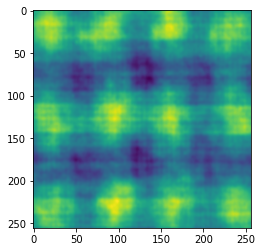

In [106]:
plt.imshow(x_sub.numpy()[0].real)

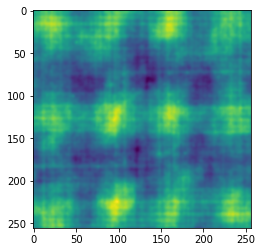

In [107]:
plt.imshow(x_full.numpy()[0].real)

# unet test

In [60]:

import numpy as np
import tensorflow as tf


class UNet(tf.keras.Model):
    def __init__(
        self, 
        image_shape, 
        uv, 
        op=None,
        depth=2, 
        start_filters=16,
        measurement_weights=1,
        conv_layers=1, 
        kernel_size=3, 
        output_activation='linear', 
        input_type="image",
        residual = True,
        batch_size=20
        ):

        # store parameters
        self.image_shape = image_shape
        self.uv = uv
        self.depth = depth
        self.start_filters = start_filters
        self.measurement_weights = measurement_weights
        self.conv_layers = conv_layers
        self.kernel_size = kernel_size 
        self.output_activation = output_activation
        self.input_type = input_type
        self.batch_size = batch_size
        self.residual = residual

        # check input type
        if input_type == "image":
            inputs = tf.keras.Input(image_shape, dtype=tf.float32)
            x = inputs
        elif input_type == "measurements":
            self.op = op # save the used operator
            m_op = self.op()
            m_op.plan(uv, image_shape, (image_shape[0]*2, image_shape[1]*2), (6,6), batch_size=batch_size) #TODO change these hardcoded values for upsampling
            assert op is not None, "Operator needs to be specified when passing measurements as input" 
            # calculate initial image using a weighted adjoint
            inputs = tf.keras.Input([m_op.n_measurements], dtype=tf.complex64)
            sel = tf.keras.Input([m_op.n_measurements], dtype=tf.bool)
            
            y_sub = tf.boolean_mask(inputs, sel[0], axis=1)
#             x = tf.math.real(m_op.adj_op_sub(inputs * measurement_weights), sel)
            x = tf.math.real(m_op.adj_op_sub(y_sub, sel[0]))
            
        else:
            raise ValueError("argument input_type should be one of ['image', 'measurements']")
        
        skips = []

        conv_kwargs = {
            "kernel_size": kernel_size,
            "activation": "relu",
            "padding": "same",
            }
        x_init = x
        x = tf.expand_dims(x, axis=3)
        x = tf.keras.layers.Conv2D(filters=start_filters, **conv_kwargs)(x)
        x = tf.keras.layers.BatchNormalization()(x)

        # convolution downward
        for i in range(depth):            
            x = self._convolutional_block(
                x, 
                conv_layers = conv_layers, 
                filters = start_filters*2**(i), # #filters increase with depth
                **conv_kwargs
            )
            skips.append(x)
            x = tf.keras.layers.MaxPool2D(padding='same')(x)

        # Lowest scale
        x = self._convolutional_block(
                x, 
                conv_layers = conv_layers, 
                filters = start_filters*2**(depth), 
                **conv_kwargs
            )

        # convolutions upward
        for i in range(depth):
            x = tf.keras.layers.Conv2DTranspose(
                filters=start_filters*2**(depth-(i+1)), # #filters increase with depth
                strides=(2,2),
                **conv_kwargs
            )(x)
            x = tf.keras.layers.BatchNormalization()(x)
            # x = tf.keras.layers.ReLU()(x)
            
            x = tf.keras.layers.Concatenate()([x,skips[-(i+1)]])

            x = self._convolutional_block(
                x, 
                conv_layers = conv_layers, 
                filters = start_filters*2**(depth-(i+1)), 
                **conv_kwargs
            )

        x = tf.keras.layers.Conv2D(
                    filters=1, 
                    kernel_size=1, 
                    padding='same',
                    activation=output_activation,
                    name="conv2d_output"
                    )(x)

        # remove extra dimension and add initial reconstruction
        if residual:
            outputs = tf.squeeze(x, axis=-1) + x_init 
        else:
            outputs = tf.squeeze(x, axis=-1)

        super().__init__(inputs=[inputs, sel], outputs=outputs)
        print(inputs, outputs)
        self.compile(optimizer='adam', loss= tf.keras.losses.MSE)

    @staticmethod
    def _convolutional_block(x, conv_layers, filters, **conv_kwargs):
        for j in range(conv_layers):
            x = tf.keras.layers.Conv2D(
                filters=filters,
                **conv_kwargs
            )(x)
            x = tf.keras.layers.BatchNormalization()(x)
        return x

    def rebuild_with_op(self, uv):
        """Rebuilds the current network with a new sampling distribution

        Args:
            uv : new sampling distribution

        Returns:
            model : model rebuild with new sampling distribution
        """
        # extract weights from current model
        weigths = [self.layers[i].get_weights() for i in range(len(self.layers))]

        # reset graph and make new model with same parameters but new sampling distribution
        tf.keras.backend.clear_session()
        model = UNet(
            self.image_shape, 
            uv,
            op=self.op, 
            depth=self.depth, 
            start_filters=self.start_filters,
            conv_layers=self.conv_layers, 
            kernel_size=self.kernel_size, 
            output_activation=self.output_activation, 
            input_type=self.input_type, 
            measurement_weights=self.measurement_weights,
            batch_size=self.batch_size
        )
        
        # transfer old weights to new model
        for i in range(len(self.layers)):
            model.layers[i].set_weights(weigths[i])
        
        return model

In [61]:
model = UNet(
    Nd, 
    uv=uv,
    op=NUFFT2D_TF, 
    depth=2, 
    conv_layers=1,
    input_type="measurements", 
    measurement_weights=1,
    batch_size=1,
    residual=True
    )


100%|██████████| 1000/1000 [00:00<00:00, 1486.99it/s]


(None, None) (1000,) (1, 1000, 36)
KerasTensor(type_spec=TensorSpec(shape=(None, 1000), dtype=tf.complex64, name='input_15'), name='input_15', description="created by layer 'input_15'") KerasTensor(type_spec=TensorSpec(shape=(1, 256, 256), dtype=tf.float32, name=None), name='tf.__operators__.add_1/AddV2:0', description="created by layer 'tf.__operators__.add_1'")


In [63]:
model.fit((y.numpy(), random_sel.reshape(1,-1)), x.reshape(1,256,256))

1/1 [==============================] - 24s 24s/step - loss: 2.0686


In [78]:
m_op = NUFFT2D_TF()
m_op.plan(uv, Nd, Kd, Jd, batch_size)

100%|██████████| 1000/1000 [00:00<00:00, 1456.73it/s]


In [79]:
tf.keras.backend.clear_session()

In [80]:
inputs = tf.keras.Input([m_op.n_measurements], dtype=tf.complex64)
sel = tf.keras.Input([m_op.n_measurements], dtype=tf.bool)

# sel = tf.math.reduce_mean(sel, axis=0)

y_sub = tf.boolean_mask(inputs, sel[0], axis=1)
#             x = tf.math.real(m_op.adj_op_sub(inputs * measurement_weights), sel)
out = tf.math.real(m_op.adj_op_sub(y_sub, sel[0]))

out = m_op.dir_op_sub(out, sel[0])

In [68]:
y_sub.shape

TensorShape([None, None])

In [81]:
model = tf.keras.Model([inputs, sel], out)
model.compile(optimizer='adam', loss= tf.keras.losses.MSE)


In [109]:
ypred = model.predict((y.numpy(), random_sel.reshape(1,-1)))

In [94]:
y.numpy()[:,random_sel][0,0]

(-0.00011199972-0.00028281653j)

In [111]:
m_op.dir_op(np.real(x_sub))[0,0]

<tf.Tensor: shape=(), dtype=complex64, numpy=(-1.5593218e-05-3.6164623e-05j)>

In [110]:
ypred[0,0]

(-1.5593196e-05-3.616457e-05j)

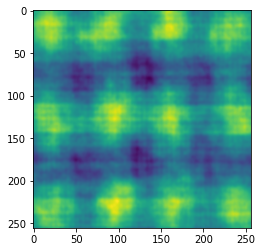

In [71]:
plt.imshow(ypred.real[0])

In [430]:
bv.shape

TensorShape([1, 1000, 36])

In [414]:
inputs.shape, m_op.batch_values.shape, bv.shape, sel.shape

(TensorShape([None, 1000]),
 (1, 1000, 36),
 TensorShape([1, 1000, 36]),
 TensorShape([1000]))

In [415]:
model.layers

In [252]:
ypred.shape

(488,)

# check generation results

In [3]:
import numpy as np

In [6]:
a = np.load("./data/intermediate/COCO/NUFFT_Random/x_true_test_30dB.npy")
b = np.load("./data/intermediate/COCO/NUFFT_Random/y_dirty_train_30dB_000.npy")
c = np.load("./data/intermediate/COCO/NUFFT_Random/sel_train_30dB_000.npy")

In [8]:
a.shape, b.shape, c.shape

((1000, 256, 256), (2000, 32767), (2000, 65536))

In [9]:
import matplotlib.pyplot as plt

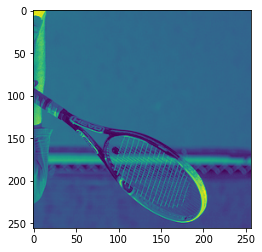

In [10]:
plt.imshow(a[0])

In [13]:
b[0]

array([ 0.01904416-0.0016421j , -0.00974499-0.01699026j,
       -0.00218029+0.00368037j, ...,  0.2062469 -0.17654462j,
        0.00170009-0.0063727j , -0.01845714-0.0121833j ], dtype=complex64)

In [12]:
c.shape

(2000, 65536)